### Anchor boxes customization by clustering

Bibliography:
- https://www.kaggle.com/code/backtracking/anchor-boxes-analysis-using-k-meanshttps://www.kaggle.com/code/backtracking/anchor-boxes-analysis-using-k-means
- https://www.peakermap.com/blogs/news/object-detection-tailoring-anchors-with-k-means
- https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/generate_ssd_anchor_box_aspect_ratios_using_k_means_clustering.ipynb


In [36]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

import numpy as np
import torch
from albumentations import ToTensorV2
from matplotlib import pyplot as plt
from torch import Tensor
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.image_list import ImageList
from torchvision.models.detection.retinanet import _default_anchorgen, RetinaNet, retinanet_resnet50_fpn_v2
import albumentations as A
from tqdm import tqdm
import seaborn as sns
import collections
from sklearn.cluster import KMeans
from src.torch_implementation.dataset import PascalVOCDataset


In [2]:
DATA_VALIDATION_DIR: str = r'../dataset/test'

In [4]:
def create_dataset(image_size: tuple[int, int], transform: A.augmentations, dataset_directory: str) -> PascalVOCDataset:
    valid_transform = A.Compose([
    transform(*image_size),
    ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.5))
    
    return PascalVOCDataset(
        data_folder=dataset_directory,
        split='test',
        single_cls=True,
        add_bckd_as_class=False,
        transform=valid_transform)

In [265]:
val_dataset = create_dataset(image_size=(2048, 2048), transform=A.RandomCrop, dataset_directory=DATA_VALIDATION_DIR)


Compute class mapping for TEST dataset


100%|██████████| 93/93 [00:00<00:00, 1311.76it/s]


In [266]:
def define_box_shape(boxes: torch.Tensor) -> tuple[np.array, np.array]:
    width_boxes = boxes[:, 2] - boxes[:, 0]
    height_boxes = boxes[:, 3] - boxes[:, 1]
    return width_boxes.numpy(), height_boxes.numpy()


dataset_anchor_boxes_sizes: dict = {
    'width': [],
    'height': []
}
for i in tqdm(range(len(val_dataset))):
    boxes = val_dataset[i][1]['boxes']
    size_boxes = define_box_shape(boxes)
    
    dataset_anchor_boxes_sizes['width'].extend(size_boxes[0])
    dataset_anchor_boxes_sizes['height'].extend(size_boxes[1])


100%|██████████| 93/93 [00:09<00:00,  9.85it/s]


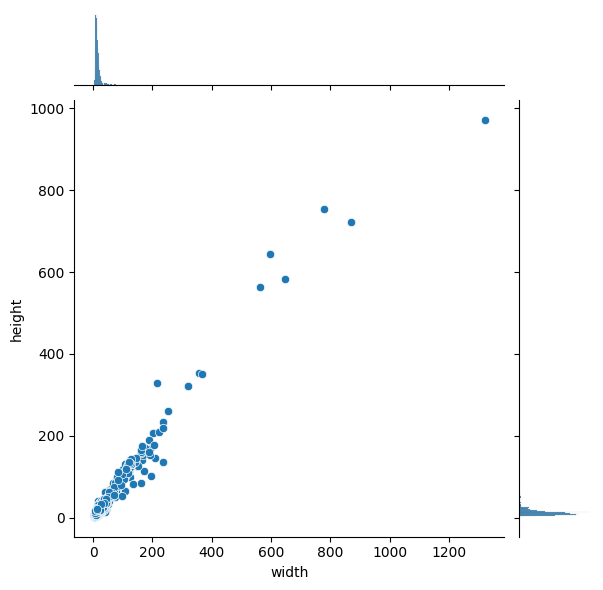

In [267]:
sns.jointplot(x="width", y="height", data=dataset_anchor_boxes_sizes)

# sns.jointplot(x="width", y="height", data=dataset_anchor_boxes_sizes, kind='kde')

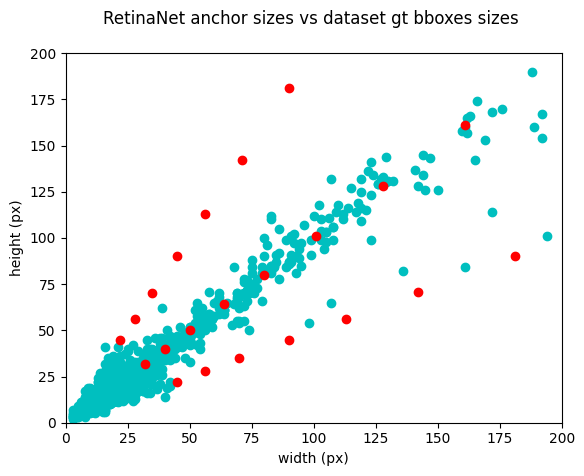

In [268]:
def get_retinaNet_anchor_sizes() -> np.array:
    default_anchor = _default_anchorgen()
    anchor_sizes: list = []
    for i in np.array(default_anchor.sizes).flatten():
        for j in list(set(np.array(default_anchor.aspect_ratios).flatten())):
            h_ratio = np.sqrt(j)
            w_ratio = 1/h_ratio
            anchor_sizes.append((int(w_ratio*i), int(h_ratio*i)))
            
    return np.array(anchor_sizes)

plt.scatter(dataset_anchor_boxes_sizes['width'], dataset_anchor_boxes_sizes['height'], color='c', label='gt bboxes')
plt.scatter(get_retinaNet_anchor_sizes()[:, 0], get_retinaNet_anchor_sizes()[:, 1], color='r', label='anchor boxes')
plt.xlim([0, 200])
plt.ylim([0, 200])
plt.title('RetinaNet anchor sizes vs dataset gt bboxes sizes \n')
plt.xlabel('width (px)')
plt.ylabel('height (px)')
plt.show()

In [219]:
# def count_base_size(width, height, input_array=[1, 8, 16, 32, 64, 96, 128, 196, 212, 256, 512, 1024]):
#     result = {}
#     for ele in input_array:
#         result[str(ele)] = 0
#     result['rest'] = 0
#     
#     for w, h in zip(width, height):
#         done = False
#         for inp in input_array:
#             if w <= inp and h <= inp:
#                 result[str(inp)] += 1
#                 done = True
#         if done == False:
#             result['rest'] += 1
#             
#     return result
#     
# D = count_base_size(dataset_anchor_boxes_sizes["width"], dataset_anchor_boxes_sizes["height"])
# OD = collections.OrderedDict(sorted(D.items()))
# plt.bar(range(len(OD)), OD.values(), align='center')
# plt.xticks(range(len(OD)), OD.keys())
# 
# plt.show()

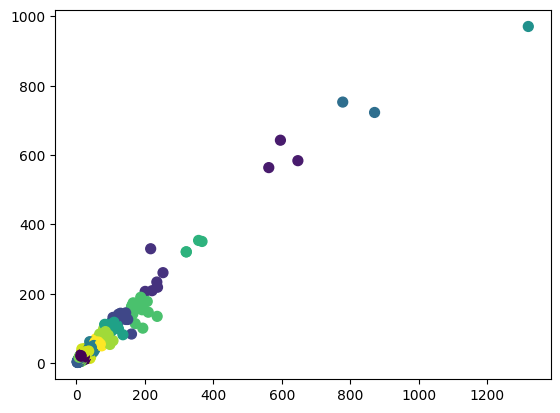

In [269]:
number_anchor_boxes_sizes: int = 15 # same as RetinaNet

X = np.vstack((np.array(dataset_anchor_boxes_sizes['width']), np.array(dataset_anchor_boxes_sizes['height']))).T
K = KMeans(number_anchor_boxes_sizes, random_state=0)
labels = K.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=labels.labels_, s=50, cmap='viridis');

In [270]:
out = labels.cluster_centers_

ar = out[:,0] / out[:,1]
scale = out[:,1] * np.sqrt(ar) / 256

print("Aspect Ratios: {}".format(np.sort(ar)))

print("Scales: {}".format(np.sort(np.mean(out, axis=1))))

Aspect Ratios: [0.93424666 0.9884571  1.0074728  1.0078168  1.0141052  1.0142233
 1.0340173  1.037462   1.0409012  1.0780125  1.1172087  1.1240873
 1.1578562  1.1612033  1.3594233 ]
Scales: [   8.002007   12.65761    18.65557    27.889732   45.240906   61.19531
   81.82222   103.867645  129.51785   168.28949   235.33334   339.12497
  599.3333    781.25     1145.5     ]


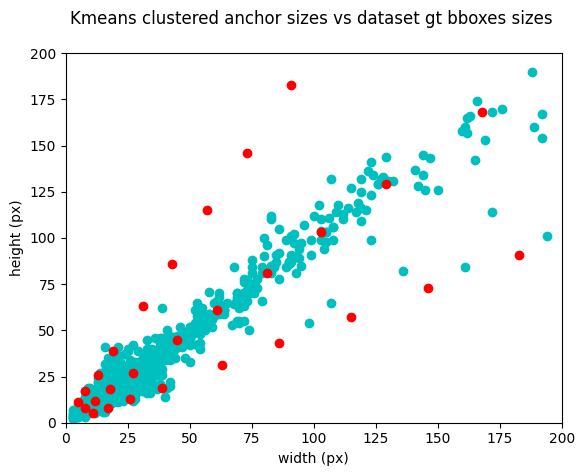

In [271]:
def get_anchor_sizes_from_clusters(cluster_sizes: np.array) -> np.array:
    default_anchor = _default_anchorgen()
    anchor_sizes: list = []
    for i in cluster_sizes:
        for j in list(set(np.array(default_anchor.aspect_ratios).flatten())):
            h_ratio = np.sqrt(j)
            w_ratio = 1/h_ratio
            anchor_sizes.append((int(w_ratio*i), int(h_ratio*i)))
            
    return np.array(anchor_sizes)

anchor_cells = get_anchor_sizes_from_clusters(np.mean(out, axis=1))
plt.scatter(dataset_anchor_boxes_sizes['width'], dataset_anchor_boxes_sizes['height'], color='c', label='gt bboxes')
plt.scatter(anchor_cells[:, 0], anchor_cells[:, 1], color='r', label='anchor boxes')
plt.xlim([0, 200])
plt.ylim([0, 200])
plt.title('Kmeans clustered anchor sizes vs dataset gt bboxes sizes \n')
plt.xlabel('width (px)')
plt.ylabel('height (px)')
plt.show()

In [272]:
def get_anchor_boxes_sizes_in_RetinaNet_format(scales: np.array) -> np.array:
    list_sizes = np.round(np.reshape(np.sort(scales), (5, 3))).astype(int).tolist()
    return tuple(tuple(x) for x in list_sizes)
    
get_anchor_boxes_sizes_in_RetinaNet_format(np.mean(out, axis=1))

((8, 13, 19), (28, 45, 61), (82, 104, 130), (168, 235, 339), (599, 781, 1146))

Call AnchorGenerator class:

In [264]:
_default_anchorgen().sizes

((32, 40, 50),
 (64, 80, 101),
 (128, 161, 203),
 (256, 322, 406),
 (512, 645, 812))

In [263]:
_default_anchorgen().aspect_ratios

((0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0))

In [262]:
AnchorGenerator(sizes=get_anchor_boxes_sizes_in_RetinaNet_format(np.mean(out, axis=1)), aspect_ratios=_default_anchorgen().aspect_ratios).cell_anchors

[tensor([[-2., -1.,  2.,  1.],
         [-3., -1.,  3.,  1.],
         [-5., -2.,  5.,  2.],
         [-2., -2.,  2.,  2.],
         [-2., -2.,  2.,  2.],
         [-4., -4.,  4.,  4.],
         [-1., -2.,  1.,  2.],
         [-1., -3.,  1.,  3.],
         [-2., -5.,  2.,  5.]]),
 tensor([[-11.,  -5.,  11.,   5.],
         [-18.,  -9.,  18.,   9.],
         [-27., -13.,  27.,  13.],
         [ -8.,  -8.,   8.,   8.],
         [-12., -12.,  12.,  12.],
         [-19., -19.,  19.,  19.],
         [ -5., -11.,   5.,  11.],
         [ -9., -18.,   9.,  18.],
         [-13., -27.,  13.,  27.]]),
 tensor([[ -40.,  -20.,   40.,   20.],
         [ -70.,  -35.,   70.,   35.],
         [-107.,  -54.,  107.,   54.],
         [ -28.,  -28.,   28.,   28.],
         [ -50.,  -50.,   50.,   50.],
         [ -76.,  -76.,   76.,   76.],
         [ -20.,  -40.,   20.,   40.],
         [ -35.,  -70.,   35.,   70.],
         [ -54., -107.,   54.,  107.]]),
 tensor([[-124.,  -62.,  124.,   62.],
         [

Clustering by IoU



In [134]:
import numpy as np

def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median, stop_iter:int = 5):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all(): # break if nothing changes
            iteration += 1
            if iteration == stop_iter:
                break
        else:
            iteration = 0

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters, np.mean(distances)

# def kmeans(bboxes:torch.tensor, k:int, dist=torch.mean, stop_iter=5):
#     rows = bboxes.shape[0]
#     distances = torch.empty((rows, k))
#     last_clusters = torch.zeros((rows, ))
# 
#     cluster_indxs = np.random.choice(rows, k, replace=False) # choose unique indexs in rows
#     clusters = bboxes[cluster_indxs].clone()
# 
#     iteration = 0
#     while True:
#         # calculate the distances 
#         distances = iou(bboxes, clusters)
# 
#         nearest_clusters = torch.argmax(distances, dim=1) # 0, 1, 2 ... K   
# 
#         if (last_clusters == nearest_clusters).all(): # break if nothing changes
#             iteration += 1
#             if iteration == stop_iter:
#                 break
#         else:
#             iteration = 0
#         # Take the mean and step for cluster coordiantes 
#         for cluster in range(k):
#             clusters[cluster] = torch.mean(bboxes[nearest_clusters == cluster], axis=0)
# 
#         last_clusters = nearest_clusters.clone()
#     return clusters, distances

In [137]:
X = np.vstack((np.array(dataset_anchor_boxes_sizes['width']), np.array(dataset_anchor_boxes_sizes['height']))).T
# Cluster with 15 centers
centroid_clusters, distances = kmeans(X, 15)

In [138]:
print("Aspect Ratios: {}".format(np.sort(centroid_clusters[:, 0] / centroid_clusters[:, 1])))

print("Scales: {}".format(np.sort(np.mean(centroid_clusters, axis=1))))
print(f"Average IoU between anchor boxes and ground-truth boxes: {distances:.3f}")

Aspect Ratios: [0.8999998 0.9764714 1.        1.        1.0093747 1.0200007 1.0625021
 1.07693   1.0909172 1.1428622 1.1875038 1.1999763 1.2499938 1.3333279
 1.379999 ]
Scales: [ 3.40094    4.328491   4.63768    5.5652466  7.111084   8.347778
  9.275391  10.821228  11.748791  13.245209  14.840576  20.405792
 31.227066  51.942005  99.40095  ]
Average IoU between anchor boxes and ground-truth boxes: 0.673


In [146]:
centroid_clusters

array([[ 4.946869 ,  4.328491 ],
       [11.748779 ,  9.893677 ],
       [ 8.656982 ,  8.038574 ],
       [99.8647   , 98.937195 ],
       [ 3.710083 ,  3.0917969],
       [11.130432 , 12.367149 ],
       [ 7.420288 ,  6.80188  ],
       [ 4.9468384,  3.710144 ],
       [21.02417  , 19.787415 ],
       [31.536255 , 30.917877 ],
       [15.359985 , 11.130432 ],
       [51.32367  , 52.56034  ],
       [14.840576 , 14.840576 ],
       [ 9.275391 ,  9.275391 ],
       [ 6.1835938,  4.9468994]], dtype=float32)

In [120]:
model = retinanet_resnet50_fpn_v2()
default_anchor = _default_anchorgen()

In [148]:
def compute_mean_distance(boxes, clusters, k):
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)
        
    return np.mean(distances)

In [167]:
np.expand_dims(np.array(default_anchor.sizes).flatten(), axis=1).shape

(15, 1)

In [174]:
retinanet_boxes = np.hstack((np.expand_dims(np.array(default_anchor.sizes).flatten(), axis=1), np.expand_dims(np.array(default_anchor.sizes).flatten(), axis=1)))

compute_mean_distance(boxes, retinanet_boxes, k=15)

0.8848434305027922

array([[ 32,  32],
       [ 40,  40],
       [ 50,  50],
       [ 64,  64],
       [ 80,  80],
       [101, 101],
       [128, 128],
       [161, 161],
       [203, 203],
       [256, 256],
       [322, 322],
       [406, 406],
       [512, 512],
       [645, 645],
       [812, 812]])

In [184]:
def get_retinaNet_anchor_sizes():
    default_anchor = _default_anchorgen()
    anchor_sizes: list = []
    for i in np.array(default_anchor.sizes).flatten():
        for j in list(set(np.array(default_anchor.aspect_ratios).flatten())):
            h_ratio = np.sqrt(j)
            w_ratio = 1/h_ratio
            anchor_sizes.append((int(w_ratio*i), int(h_ratio*i)))
            
    return np.array(anchor_sizes)
get_retinaNet_anchor_sizes()

array([[  45,   22],
       [  32,   32],
       [  22,   45],
       [  56,   28],
       [  40,   40],
       [  28,   56],
       [  70,   35],
       [  50,   50],
       [  35,   70],
       [  90,   45],
       [  64,   64],
       [  45,   90],
       [ 113,   56],
       [  80,   80],
       [  56,  113],
       [ 142,   71],
       [ 101,  101],
       [  71,  142],
       [ 181,   90],
       [ 128,  128],
       [  90,  181],
       [ 227,  113],
       [ 161,  161],
       [ 113,  227],
       [ 287,  143],
       [ 203,  203],
       [ 143,  287],
       [ 362,  181],
       [ 256,  256],
       [ 181,  362],
       [ 455,  227],
       [ 322,  322],
       [ 227,  455],
       [ 574,  287],
       [ 406,  406],
       [ 287,  574],
       [ 724,  362],
       [ 512,  512],
       [ 362,  724],
       [ 912,  456],
       [ 645,  645],
       [ 456,  912],
       [1148,  574],
       [ 812,  812],
       [ 574, 1148]])

In [144]:
default_anchor.cell_anchors, len(default_anchor.cell_anchors)

([tensor([[-23., -11.,  23.,  11.],
          [-28., -14.,  28.,  14.],
          [-35., -18.,  35.,  18.],
          [-16., -16.,  16.,  16.],
          [-20., -20.,  20.,  20.],
          [-25., -25.,  25.,  25.],
          [-11., -23.,  11.,  23.],
          [-14., -28.,  14.,  28.],
          [-18., -35.,  18.,  35.]]),
  tensor([[-45., -23.,  45.,  23.],
          [-57., -28.,  57.,  28.],
          [-71., -36.,  71.,  36.],
          [-32., -32.,  32.,  32.],
          [-40., -40.,  40.,  40.],
          [-50., -50.,  50.,  50.],
          [-23., -45.,  23.,  45.],
          [-28., -57.,  28.,  57.],
          [-36., -71.,  36.,  71.]]),
  tensor([[ -91.,  -45.,   91.,   45.],
          [-114.,  -57.,  114.,   57.],
          [-144.,  -72.,  144.,   72.],
          [ -64.,  -64.,   64.,   64.],
          [ -80.,  -80.,   80.,   80.],
          [-102., -102.,  102.,  102.],
          [ -45.,  -91.,   45.,   91.],
          [ -57., -114.,   57.,  114.],
          [ -72., -144.,   7